## OHP He estimation-impulsive varying He

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

In [3]:
using LaTeXStrings

ArgumentError: ArgumentError: Package LaTeXStrings not found in current path:
- Run `import Pkg; Pkg.add("LaTeXStrings")` to install the LaTeXStrings package.


In [4]:
cd(dirname(pwd()))
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing


## Initialization

In [5]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;


    γ = 1.3;#not 1.4!!!!! maybe 1.33?

In [6]:
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

In [7]:
tube = Tube(L,L2D,alpha)

Tube(4.0, 2.0, 1.5707963267948966)

In [8]:
Xe = map(tuple, [0.0; 3.0], [1.0; 4.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)])

In [9]:
Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)])

In [10]:
X0 = [(1.5,3.5)]
dXdt0 = [(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)])

In [11]:
P = [1.0,1.0]

vapors=VaporPlug(γ,P)

VaporPlug(1.3, [1.0, 1.0])

In [12]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(4.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)]), LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)]), VaporPlug(1.3, [1.0, 1.0]))

## Get numerical solution

In [13]:
Lvaporplug = XptoLvaporplug(X0,L)
M = P.^(1/γ).* Lvaporplug

u=vcat(XMtovec(sys0.liquidslug.Xp,sys0.liquidslug.dXdt,M), He...)

7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## Heaviside function

In [14]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))

heaviside (generic function with 1 method)

## Standard deviation function

In [15]:
    function std_EnKF(estimation_state)

    matr_state = zeros(Float64, (length(estimation_state),length(estimation_state[1]),length(estimation_state[1][1])))
    
    # filter_state = zeros(length(estimation_state),size(estimation_state[1]))
    for i = 1:length(estimation_state)
        matr_state[i,:,:] = collect(deepcopy(hcat(estimation_state[i]...)'))
    end

    std_state = zeros(Float64, (length(estimation_state), length(estimation_state[1][1])))
    for i = 1:size(matr_state,1)
        for j = 1:size(matr_state,3)
            std_state[i,j] = std(matr_state[i,:,j])
        end
    end
    return std_state
end

std_EnKF (generic function with 1 method)

## EnKF PropagationFunction

In [16]:
function zhang2002modelEnKFtruth!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = p

    # added He as a state vector entry
    u = uEnKF[1:end-1]
    uHe = deepcopy(uEnKF[end]) + 9*deepcopy(uEnKF[end])*heaviside.(t-tspan[end]/2)
#     uHe = deepcopy(uEnKF[end]) + 1*deepcopy(uEnKF[end])*t/tspan[end]-

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)


    P = real.((M./Lvaporplug .+ 0im).^(γ))

    θ = real.((P .+ 0im).^((γ-1)/γ))


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002modelEnKF(Xpvapor,θ,sys,uHe)
    
    du[end]=0.0

    return du

end

zhang2002modelEnKFtruth! (generic function with 1 method)

In [17]:
function zhang2002modelEnKF!(du::Array{Float64,1},uEnKF::Array{Float64,1},p::PHPSystem,t::Float64)

    sys = p

    # added He as a state vector entry
    u = uEnKF[1:end-1]
    uHe = deepcopy(uEnKF[end])

    numofliquidslug =  Integer( (length(u) - 1)/5 )
    
    (Xp,dXdt0,M)=vectoXM(u)

    γ = sys.liquidslug.γ
    ω0 = sys.liquidslug.ω0
    ℘ = sys.liquidslug.℘
    Lvaporplug = XptoLvaporplug(Xp,sys.tube.L)
#     Lliquidslug = XptoLliquidslug(Xp)
    height = getheight(Xp,sys.tube.L2D,sys.tube.alpha)
    Xpvapor = getXpvapor(Xp,sys.tube.L)


    P = real.((M./Lvaporplug .+ 0im).^(γ))

    θ = real.((P .+ 0im).^((γ-1)/γ))


    for i = 1:numofliquidslug
        du[2*i-1] = u[2*numofliquidslug+2*i-1]
        du[2*i] = du[2*i-1]

        du[2*numofliquidslug + 2*i-1] = -32*u[2*numofliquidslug + 2*i-1] - (ω0[i]^2)*(0.5*(height[i][end]-height[i][1])) + ℘[i]*(P[i]-P[i+1])
        du[2*numofliquidslug + 2*i] = du[2*numofliquidslug + 2*i-1]

    end


        du[4*numofliquidslug+1:5*numofliquidslug+1] .= dMdtzhang2002modelEnKF(Xpvapor,θ,sys,uHe)
    
    du[end]=0.0

    return du

end


function dMdtzhang2002modelEnKF(Xpvapor::Array{Tuple{Float64,Float64},1},θ::Array{Float64,1},sys::PHPSystem,uHe)

    dMdt=zeros(length(Xpvapor))


    Xe = sys.evaporator.Xe
    He = uHe
    θe = sys.evaporator.θe

    Xc = sys.condenser.Xc
    Hc = sys.condenser.Hc
    θc = sys.condenser.θc

    Levapoverlap=XpvaportoLoverlap(Xpvapor,Xe)
    Lcondoverlap=XpvaportoLoverlap(Xpvapor,Xc)


    # May not be right for multi liquid flow
    for i = 1:length(Xpvapor)
        if Lcondoverlap[i] < 1e-8
            dMdt[i] = He * Levapoverlap[i] * (θe-θ[i])
        else
            dMdt[i] = -Hc * Lcondoverlap[i] * (θ[i]-θc)
        end
    end

    return dMdt

end

dMdtzhang2002modelEnKF (generic function with 1 method)

In [18]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 0.1);
T = tspan[1]:tstep:tspan[end]

prob = ODEProblem(zhang2002modelEnKFtruth!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=tstep);
integrator = init(prob, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

## EnKF

In [84]:
probEnKF = ODEProblem(zhang2002modelEnKF!, u, tspan, p)
solEnKF = solve(probEnKF, RK4(), adaptive=false, dt=tstep);
integrator = init(probEnKF, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 7-element Array{Float64,1}:
    1.5
    3.5
    0.0
    0.0
    1.5
    0.5
 3000.0

In [85]:
newHe = 0.0

0.0

In [86]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
#         for j=1:10
        step!(integrator)
#         end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [87]:
fprop = PropagationFunction()

PropagationFunction()

In [88]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    result=soltoResult(s[1:end-1],sys0);
#     return [s[3]]
    return [deepcopy(result.θ[1]),deepcopy(result.θ[2])]
end

In [89]:
function (::MeasurementFunction)(t::Float64) 
#     return reshape([0.0, 0.0, 1.0, 0.0, 0.0, 0.0],(1,6))
    return reshape([1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0,0.0],(2,7))
end

In [90]:
m = MeasurementFunction()

MeasurementFunction()

In [91]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
#     fill!(ENS, [deepcopy(s[3])])
        result=soltoResult(s[1:end-1],sys0);
    fill!(ENS, [deepcopy(result.θ[1]),deepcopy(result.θ[2])])
    end
    return ENS
end

In [92]:
z = RealMeasurementFunction()

RealMeasurementFunction()

In [93]:
# A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(1), 2.0*I))
A = MultiAdditiveInflation(7, 1.001, MvNormal(zeros(7), 0.00001*Diagonal([1.0,1.0,100000.0,100000.0,1.0,1.0,1000000000000.0])))
# A = MultiAdditiveInflation(7, 1.001, MvNormal(zeros(7), 0.00001*Diagonal([100.0,100.0,1000000.0,1000000.0,100.0,100.0,1000000000000.0])))
# A = IdentityInflation()

MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 1.0e7]
)
)

In [94]:
# this is measurement noise!!!!!!!!
# ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))
ϵ = AdditiveInflation(MvNormal(zeros(2), 0.00001*I))

AdditiveInflation{2}(IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0e-5 0.0; 0.0 1.0e-5]
)
)

In [95]:
N = 50
# NZ = 1
NZ = 2
isinflated = true
isfiltered = false
isaugmented = true

true

In [96]:
x₀ = [1.0, 3.0, 0.0, 0.0, 1.0, 1.0, newHe]
ens = initialize(N, MvNormal(x₀, 1^2*Diagonal([1.0,1.0,100.0,100.0,1.0,1.0,1000.0].^2)))
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []

0-element Array{Any,1}

In [97]:
g = FilteringFunction()

FilteringFunction()

In [98]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,2}(PropagationFunction(), MultiAdditiveInflation{7}(1.001, DiagNormal(
dim: 7
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-5 0.0 … 0.0 0.0; 0.0 1.0e-5 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-5 0.0; 0.0 0.0 … 0.0 1.0e7]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{2}(IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0e-5 0.0; 0.0 1.0e-5]
)
), true, false, true)

In [99]:
Δt = 1e-5
Tsub = 0.0:Δt:0.1-Δt

for (n,t) in enumerate(Tsub)

    global ens
    
    t, ens, cov = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    push!(covs, deepcopy(cov))
    

end

## Get standard deviation

In [100]:
std_state = std_EnKF(estimation_state);

## Show the results

In [101]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)
# ŝ =  hcat(solEnKF(T).u...)

results=soltoResult(sol[1:end-1,:],sys0);
resultŝ=soltoResult(ŝ[1:end-1,:],sys0);
# resultŝ=soltoResult(solEnKF[1:end-1,:],sys0);



## Get temperature standard deviation

In [102]:
function std_T_EnKF(estimation_state,p)

    matr_state = zeros(Float64, length(estimation_state[1][1]),(length(estimation_state[1])),length(estimation_state),)
    
    # filter_state = zeros(length(estimation_state),size(estimation_state[1]))
    for i = 1:length(estimation_state)
        matr_state[:,:,i] = collect(deepcopy(hcat(estimation_state[i]...)))
    end

T_state = zeros(Float64, (length(soltoResult(matr_state[1:end-1,1,:],p).θ), length(estimation_state),  length(estimation_state[1])))
     for i = 1:size(T_state,3)
        for j = 1:size(T_state,1)
        T_state[j,:,i] = soltoResult(matr_state[1:end-1,i,:],p).θ[j]
        end
     end

std_T_state = zeros(Float64, (size(T_state,1), size(T_state,2)))
    for i = 1:size(std_T_state,1)
        for j = 1:size(std_T_state,2)
            std_T_state[i,j] = std(T_state[i,j,:])
        end
    end


std_T_state'
end

std_T_EnKF (generic function with 1 method)

In [103]:
std_T_state=std_T_EnKF(estimation_state,p);

In [104]:
estimation_state[1][1]

7-element Array{Float64,1}:
    1.2997278651948003
    3.8270664412831428
 -114.89658552916065  
   -3.3220855762325323
    0.3484931274307026
    1.11406547013718  
  732.4063339933908   

## Get heat flux and deviation

In [105]:
function Q_EnKF(estimation_state::Array{Array{Array{Float64,1},1},1},p)

    matr_state = zeros(Float64, length(estimation_state[1][1]),(length(estimation_state[1])),length(estimation_state),)

    num_liquid = length(soltoResult(matr_state[1:end-1,1,:],p).θ)
    
    # filter_state = zeros(length(estimation_state),size(estimation_state[1]))
    for i = 1:length(estimation_state)
        matr_state[:,:,i] = collect(deepcopy(hcat(estimation_state[i]...)))
    end

Q_state = zeros(Float64, (length(soltoResult(matr_state[1:end-1,1,:],p).θ),length(estimation_state[1]), length(estimation_state)))
#      for i = 1:size(Q_state,1)
        for j = 1:size(Q_state,2)
            for k = 1:size(Q_state,3)
                u_temp = deepcopy(matr_state[:,j,k])
                Q_state[:,j,k] = zhang2002modelEnKFtruth!(u_temp,u_temp,p,0.0)[2*num_liquid+1:end-1]
            end
        end
#      end

std_Q_state = zeros(Float64, (size(Q_state,1), size(Q_state,3)))
mean_Q_state = zeros(Float64, (size(Q_state,1), size(Q_state,3)))
    for i = 1:size(std_Q_state,1)
        for j = 1:size(std_Q_state,2)
            std_Q_state[i,j] = std(Q_state[i,:,j])
            mean_Q_state[i,j] = mean(Q_state[i,:,j])
        end
    end


return mean_Q_state,std_Q_state
end

Q_EnKF (generic function with 1 method)

In [106]:
Qŝ,std_Qŝ=Q_EnKF(estimation_state,p)
Qs,std_Qs=Q_EnKF(estimation_state,p)

([255.65271381884398 -19.14600533480746 … -55.20954722109003 -54.79844373050263; 62.45723011522886 119.12774073356617 … 531.3686488389209 566.544245287592], [693.1296360015867 463.7808968155042 … 3.7866133225752443 3.9386856713512164; 469.1980500946175 558.5671968235852 … 174.17287881875959 198.48156886725582])

In [107]:
u_temp0 = deepcopy(sol.u[9000])

7-element Array{Float64,1}:
    0.44016013226253253
    2.4401601322625273 
 -216.5951468999932    
 -216.5951468999932    
    0.7625535901679609 
    1.2739779777421025 
 3000.0                

In [108]:
num_liquid = Int((length(deepcopy(sol.u[1]))-1)/3)


Qs = zeros(size(Qŝ))
for i = 1:size(Qs,1)
    for j = 1:size(Qs,2)
        u_temp = deepcopy(sol.u[j])
        Qs[i,j]=zhang2002modelEnKFtruth!(u_temp,u_temp, p,sol.t[j])[2*num_liquid+i]
    end
end


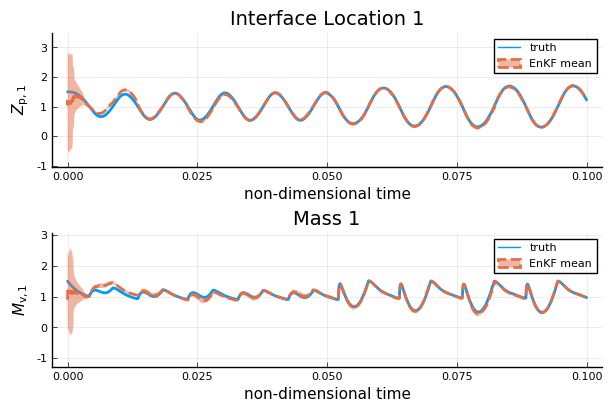

In [120]:
plt1 = plot(layout = (2, 1), legend = :topright)
plot!(plt1[1], T, results.Xp[1][1:end-1], linewidth = 2, label = "truth")
plot!(plt1[1], Tsub, resultŝ.Xp[1][1:end-1], linewidth = 2, ribbon = 2*std_state[:,1], markersize = 2, label = "EnKF mean", xlabel = "non-dimensional time", ylabel = "\$Z_{\\mathrm{p},1}\$", linestyle =:dash,title="Interface Location 1")

plot!(plt1[2], T, results.M[1][1:end-1], linewidth = 2, label = "truth")
plot!(plt1[2], Tsub, resultŝ.M[1][1:end-1], linewidth = 2, ribbon = 2*std_state[:,5], markersize = 2, label = "EnKF mean", xlabel = "non-dimensional time", ylabel = "\$M_{\\mathrm{v},1}\$", linestyle =:dash,title="Mass 1")

savefig(plt1,"EnKF_X location and mass.pdf")

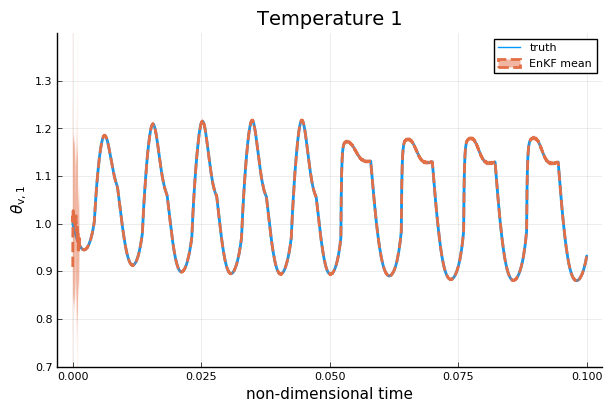

In [121]:
plt2 = plot(layout = (1, 1), legend = :topright)

plot!(plt2[1], T, results.θ[1][1:end-1], linewidth = 2, label = "truth")
plot!(plt2[1], Tsub, resultŝ.θ[1][1:end-1], linewidth = 2, ribbon = 2*std_T_state[:,1], markersize = 2, label = "EnKF mean", xlabel = "non-dimensional time", ylabel = "\$\\theta_{\\mathrm{v},1}\$", linestyle =:dash,title="Temperature 1", ylim=(0.7,1.4))

savefig(plt2,"EnKF_temperature.pdf")

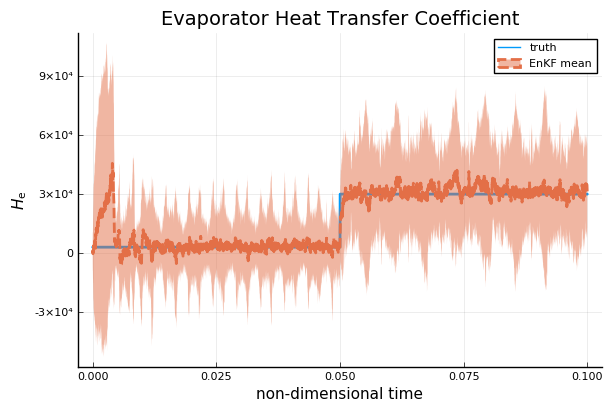

In [122]:
plt3 = plot(layout = (1, 1), legend = :topright)

plot!(plt3[1], T, (sol[end,1:end-1] + 9*sol[end,1:end-1].*heaviside.(T .- tspan[end]/2)), linewidth = 2, label = "truth")
plot!(plt3[1], Tsub, ŝ[7,1:end-1], linewidth = 2, ribbon = 2*std_state[:,7], markersize = 2, label = "EnKF mean", xlabel = "non-dimensional time", ylabel = "\$H_{\\mathrm{e}}\$", linestyle =:dash,title="Evaporator Heat Transfer Coefficient")

savefig(plt3,"EnKF_He.pdf")

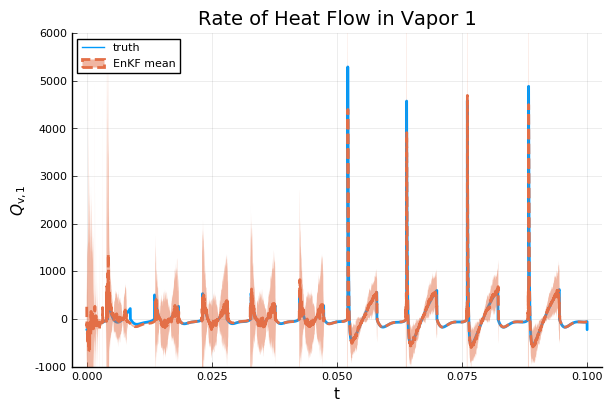

In [123]:
plt4 = plot(layout = (1, 1), legend = :topleft)

plot!(plt4[1], T, Qs[1,1:end-1], linewidth = 2, label = "truth",ylim=(-1000,6000))
plot!(plt4[1], Tsub, Qŝ[1,1:end-1], linewidth = 2, ribbon = 2*std_Qŝ[1,1:end-1], markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "\$Q_{\\mathrm{v},1}\$", linestyle =:dash,title="Rate of Heat Flow in Vapor 1")

savefig(plt4,"Rate of Heat Flow.pdf")

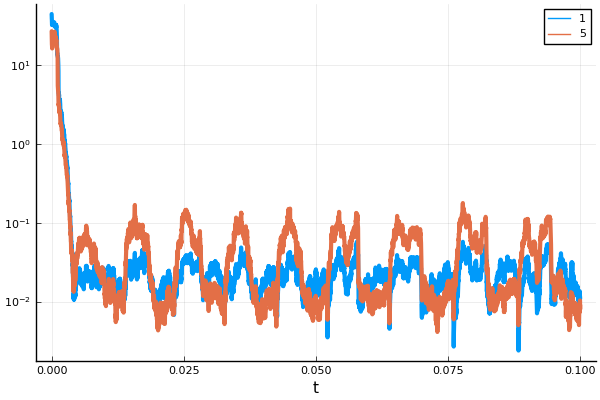

In [113]:
plot(Tsub, map(covs) do P  
        P[1,1]+ eps() end, yscale = :log10, linewidth = 3, label = "1")
plot!(Tsub, map(covs) do P
        P[5,5]+ eps() end, yscale = :log10, linewidth = 3, xlabel = "t", label = "5")

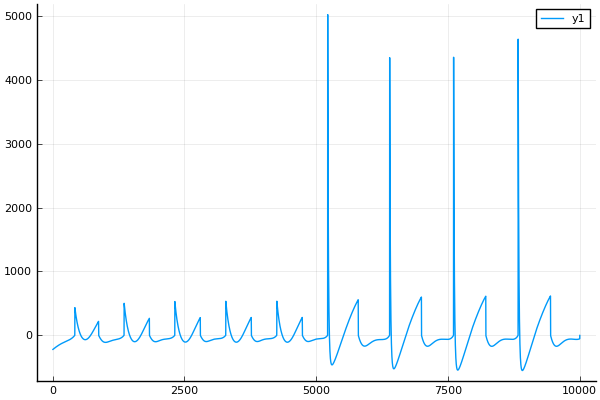

In [114]:
diffM = zeros(length(results.M[1])-1)
for i=2:length(results.M[1])
    diffM[i-1] = (results.M[1][i]-results.M[1][i-1])/(sol.t[2]-sol.t[1])
end

plot(diffM)

In [115]:
tspan

(0.0, 0.1)